In [1]:
import os
import sys
from datetime import datetime

In [2]:
# -------------------------------------------------------------
# Environment setup
# -------------------------------------------------------------
BASE_DIR = os.path.abspath("../")
sys.path.append(BASE_DIR)

# -------------------------------------------------------------
# Configuration
# -------------------------------------------------------------
from src.utils.config import load_config
config = load_config(base_dir=BASE_DIR)

In [3]:

import pandas as pd
import numpy as np
import dask.dataframe as dd

import torch
import torch.nn.functional as F
from itertools import product
import time
from tqdm import tqdm


## Recovery sessions

Dado:
Sesion de TX
s = {cliente, timestamp, Monto}

    Cada cliente tiene una secuencia de sesiones de TX (S)
        S = { s1, s2 , s3, ..., sn}          n: # de sesiones de cada cliente

- “Feature Engineering for Machine Learning” — Zheng & Casari (O’Reilly, 2018) 
  <!-- capítulo 4: Log-transform para montos financieros y variables con heavy-tail. -->
- "Modeling Loss Distributions" — Klugman, Panjer & Willmot (Actuarial Mathematics, 2012)
- "The Elements of Statistical Learning" (Hastie, Tibshirani, Friedman)
  <!-- Transformaciones logarítmicas estabilizan varianza para algoritmos basados en distancia. -->

Si tienes valores de 0 soles → log(0) es indefinido.

**Solución**: log(1+x)
Esto es un estándar industrial:
 - Scikit-Learn: sklearn.preprocessing.FunctionTransformer(np.log1p)
 - Spark ML: log1p aplicado a ingresos y montos

In [103]:
file_path = config["paths"]["session_records"]
data_sessions = pd.read_parquet(file_path)

# Feedback
data_sessions["amount_log"] = np.log1p(data_sessions["amount_sol"])
data_sessions = data_sessions[data_sessions['client_age']<=80].reset_index(drop=True)
data_sessions = data_sessions[data_sessions['mccg']!=0].reset_index(drop=True)

# data_sessions = dd.read_parquet(file_path)
data_sessions.head(2)

,id,client_id,mcc,amount_sol,client_age,client_gender,agency_ubigeo,debit_type,timestamp,mccg,windows_time,day_of_week,hour,turn_of_day,amount_log
0,27634759,XxgXt1gGsxk=,5541,100.0,53,M,150140.0,TD,2017-02-05 15:45:25-05:00,8,2017-01-30,6,15,2,4.615121
1,27634839,by4Jhi0/BVI=,5541,20.0,49,M,70102.0,TD,2017-05-19 13:07:38-05:00,8,2017-05-15,4,13,2,3.044522


In [5]:
data_sessions.dtypes

id                                                int64
client_id                                        object
mcc                                               int64
amount_sol                                      float64
client_age                                        int64
client_gender                                    object
agency_ubigeo                                   float64
debit_type                                       object
timestamp        datetime64[ns, pytz.FixedOffset(-300)]
mccg                                              int64
windows_time                                     object
day_of_week                                       int64
hour                                              int64
turn_of_day                                       int64
dtype: object

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_distribution(
    df, 
    col, 
    title=None,
    bins="auto", 
    kde=True,
    figsize=(8,4),
    clip_percentile=99.5,  # para cortar colas extremas
    y_from_zero=True, 
):
    """
    Plotea distribución de una variable numérica:
    - histograma
    - KDE opcional
    - líneas de media y mediana
    - recorte de outliers para mejor visualización
    """

    series = pd.to_numeric(df[col], errors="coerce").dropna()

    # --- Clipping para evitar colas enormes ---
    if clip_percentile is not None:
        limit = np.percentile(series, clip_percentile)
        series = series[series <= limit]

    mean_val = series.mean()
    median_val = series.median()

    plt.figure(figsize=figsize)

    sns.histplot(series, bins=bins, kde=kde, stat="density", alpha=0.4)

    # Media y mediana
    plt.axvline(mean_val, color="red", linestyle="--", linewidth=1.5, label=f"Media: {mean_val:.2f}")
    plt.axvline(median_val, color="green", linestyle=":", linewidth=1.5, label=f"Mediana: {median_val:.2f}")

    if y_from_zero:
        plt.ylim(bottom=0)

    plt.title(title or f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Densidad")
    plt.grid(alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

def plot_horizontal_bar(
    df,
    col,
    title=None,
    top=None,
    figsize=None,
    normalize=False,
    min_height=0.3,
):
    """
    Gráfico de barras horizontal elegante:
    - Ajusta tamaño automáticamente según número de categorías.
    - Opcionalmente muestra porcentajes (normalize=True).
    - Evita gráficos vacíos o apiñados.
    - Permite top-N.
    """

    # --------------------
    # Conteo de valores
    # --------------------
    counts = df[col].value_counts()

    if counts.empty:
        print("⚠ No hay datos para plotear.")
        return

    # --------------------
    # Top N opcional
    # --------------------
    if top is not None:
        counts = counts.head(top)   # top N más frecuentes
    else:
        counts = counts

    # Orden ascendente para barras horizontales
    counts = counts.sort_values()

    # --------------------
    # Normalizar (porcentajes)
    # --------------------
    if normalize:
        counts = counts / counts.sum()
        xlabel = "Porcentaje"
    else:
        xlabel = "Frecuencia"

    # --------------------
    # Ajuste automático de alto
    # --------------------
    n = len(counts)
    height = max(n * min_height, 4)  # garantiza que no sea demasiado pequeño

    if figsize is None:
        figsize = (10, height)

    # --------------------
    # Plot
    # --------------------
    plt.figure(figsize=figsize)
    plt.barh(counts.index.astype(str), counts.values, color="steelblue", alpha=0.85)

    plt.xlabel(xlabel)
    plt.ylabel(col)
    plt.title(title or f"Distribución de {col}")

    # Mostrar grid solo en eje X
    plt.grid(axis="x", alpha=0.3)

    # Evita que se corten etiquetas
    plt.tight_layout()
    plt.show()


    

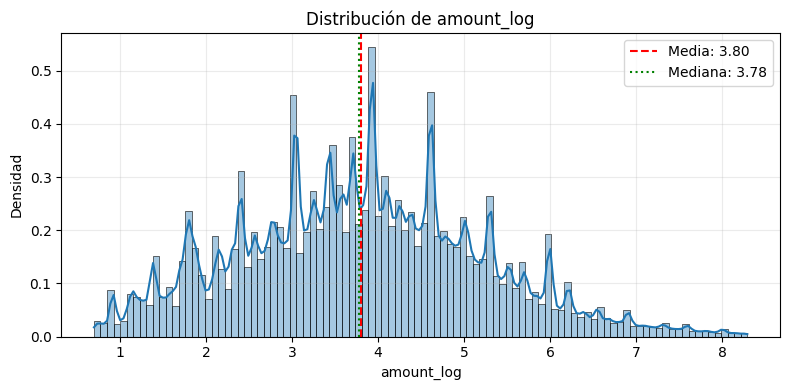

In [ ]:
plot_distribution(data_sessions, "amount_log", bins=100)


In [104]:
len(set(data_sessions['client_age']))


63

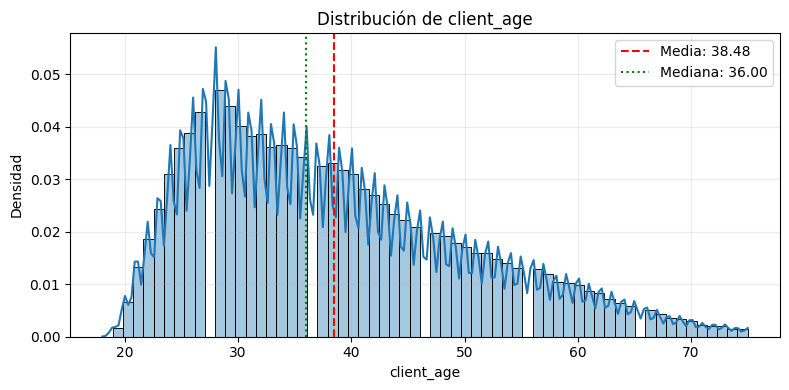

In [105]:
plot_distribution(data_sessions, "client_age", bins=63)


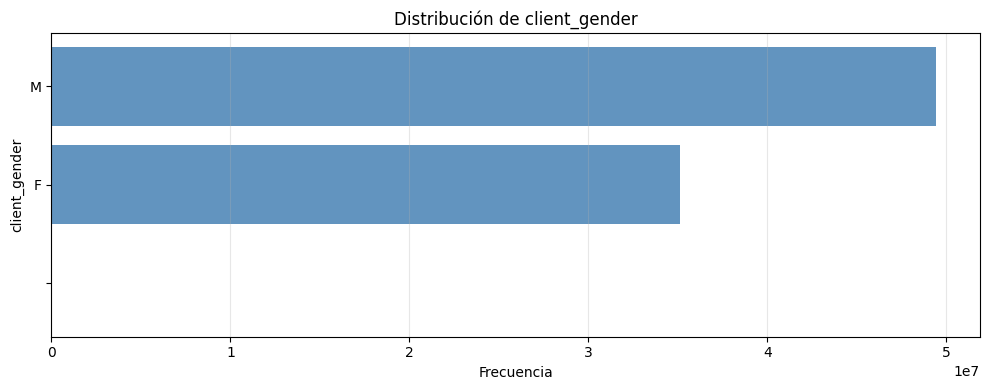

In [143]:
plot_horizontal_bar(data_sessions, "client_gender")

In [160]:
# plot_horizontal_bar(data_sessions, "agency_ubigeo")

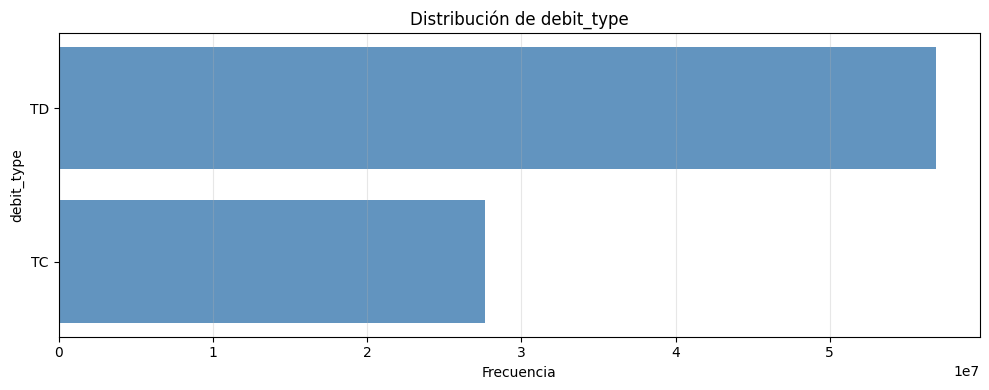

In [158]:
plot_horizontal_bar(data_sessions, "debit_type")

In [86]:
len(set(data_sessions['hour']))

24

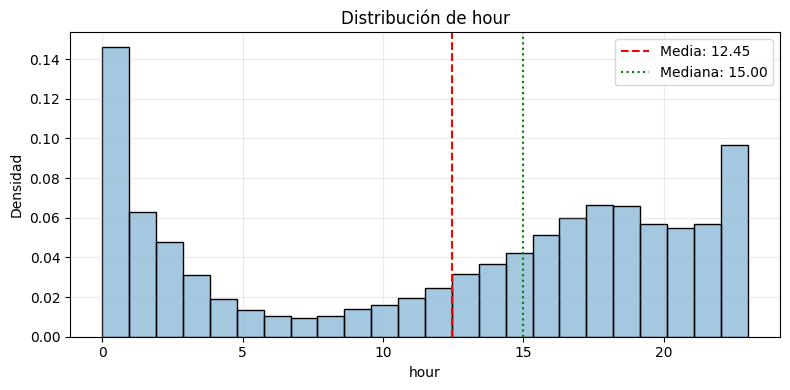

In [87]:
plot_distribution(data_sessions, "hour", bins=24, kde=False)


In [88]:
len(set(data_sessions['mccg']))

13

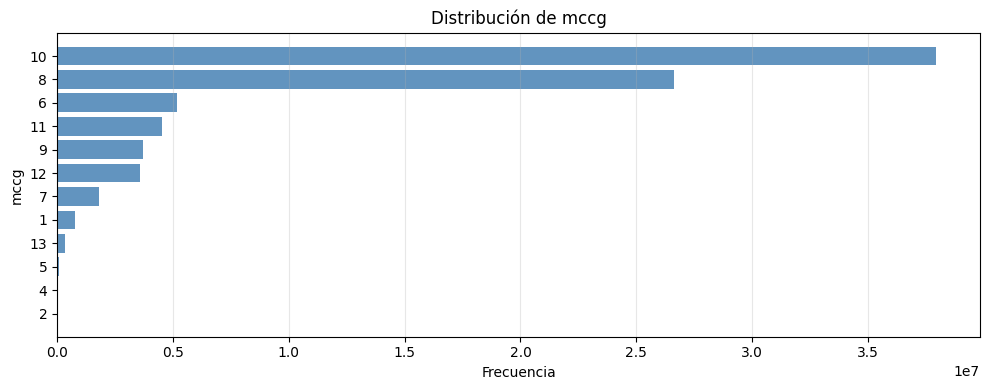

In [144]:
plot_horizontal_bar(data_sessions, "mccg")


In [145]:
len(set(data_sessions['mcc']))

600

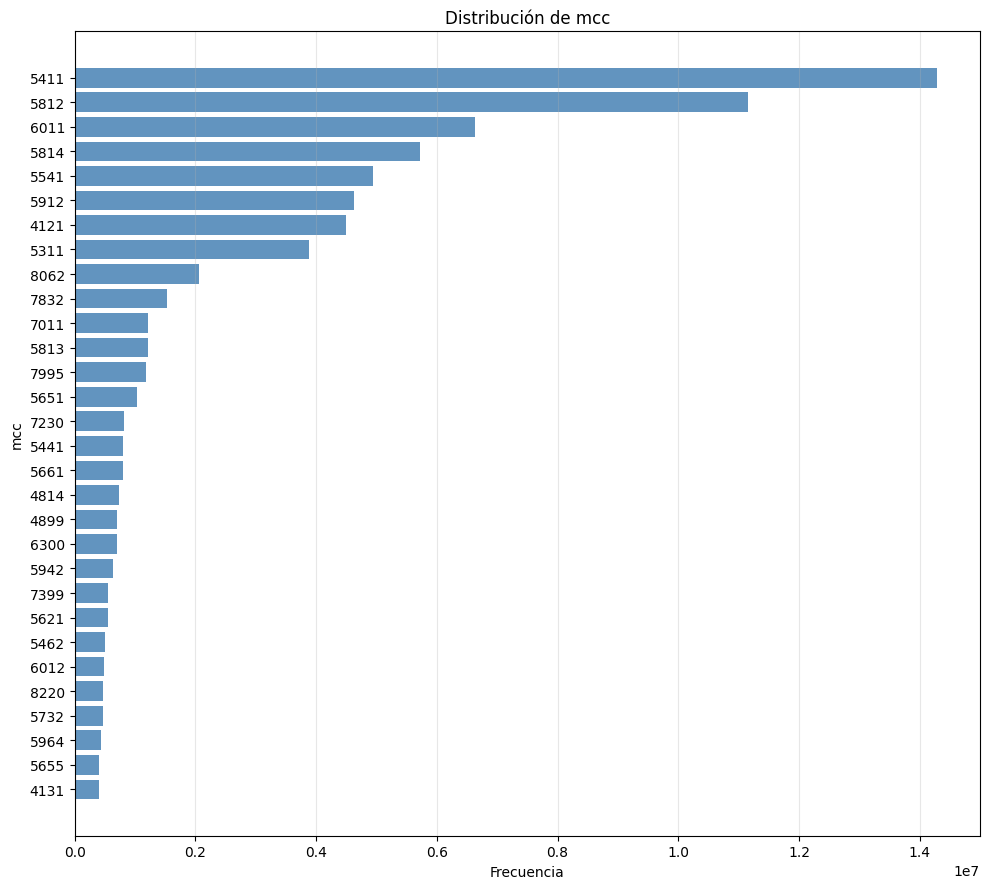

In [146]:
plot_horizontal_bar(data_sessions, "mcc", top=30)


In [111]:
data_sessions["amount_log"].describe()

count    8.456198e+07
mean     3.777744e+00
std      1.343762e+00
min      6.981347e-01
25%      2.867899e+00
50%      3.758872e+00
75%      4.615121e+00
max      1.375005e+01
Name: amount_log, dtype: float64

In [112]:
data_sessions["amount_sol"].describe()

count    8.456198e+07
mean     1.403559e+02
std      9.826343e+02
min      1.010000e+00
25%      1.660000e+01
50%      4.190000e+01
75%      1.000000e+02
max      9.366380e+05
Name: amount_sol, dtype: float64

In [115]:
data_sessions.head()

,id,client_id,mcc,amount_sol,client_age,client_gender,agency_ubigeo,debit_type,timestamp,mccg,windows_time,day_of_week,hour,turn_of_day,amount_log
0,27634759,XxgXt1gGsxk=,5541,100.0,53,M,150140.0,TD,2017-02-05 15:45:25-05:00,8,2017-01-30,6,15,2,4.615121
1,27634839,by4Jhi0/BVI=,5541,20.0,49,M,70102.0,TD,2017-05-19 13:07:38-05:00,8,2017-05-15,4,13,2,3.044522
2,27634758,uY+MrfQgDFU=,5541,80.0,48,F,80108.0,TD,2017-01-31 18:31:02-05:00,8,2017-01-30,1,18,3,4.394449
3,27634763,oTkd8whgjrI=,5541,100.0,48,F,70104.0,TD,2016-11-07 19:26:22-05:00,8,2016-11-07,0,19,3,4.615121
4,27634888,bvbaaID5i+g=,5541,20.0,48,M,150122.0,TD,2016-12-05 00:57:48-05:00,8,2016-12-05,0,0,0,3.044522


# Lines

In [147]:
def plot_amount_by_mcc(df, amount_col="amount_sol", mcc_col="mccg", 
                       top=None, figsize=(10,6)):
    
    g = df.groupby(mcc_col)[amount_col]

    median = g.median()
    q1 = g.quantile(0.25)
    q3 = g.quantile(0.75)

    # Ordenar por mediana
    median = median.sort_values()
    q1 = q1.loc[median.index]
    q3 = q3.loc[median.index]

    # Filtrar top N si se desea
    if top:
        median = median.tail(top)
        q1 = q1.loc[median.index]
        q3 = q3.loc[median.index]

    x = np.arange(len(median))

    plt.figure(figsize=figsize)

    # Línea de mediana
    plt.plot(x, median.values, marker='o', label="Mediana del monto")

    # Banda IQR (Q1–Q3)
    plt.fill_between(
        x,
        q1.values,
        q3.values,
        alpha=0.25,
        label="IQR (Q1–Q3)"
    )

    plt.xticks(x, median.index, rotation=90)
    plt.ylabel("Monto")
    plt.title("Monto por MCC (Mediana + IQR)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


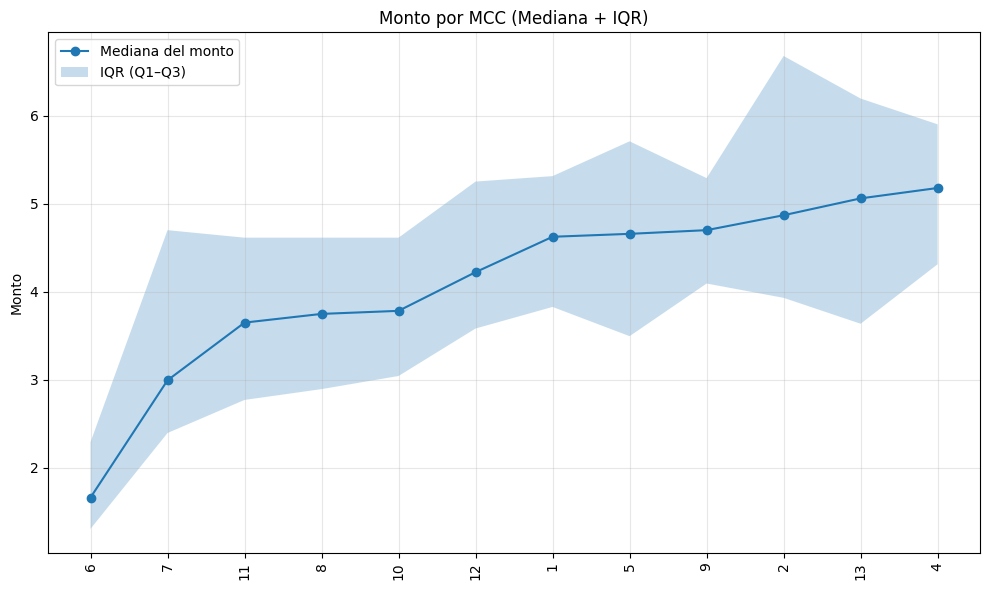

In [148]:
plot_amount_by_mcc(data_sessions, amount_col="amount_log", mcc_col="mccg")

In [149]:
def plot_log_amount_by_mcc(df, amount_log="amount_log", mcc_col="mcc",
                           top=None, figsize=(12,5)):
    
    g = df.groupby(mcc_col)[amount_log]

    mean = g.mean()
    std = g.std().fillna(0)

    # Ordenar por media
    mean = mean.sort_values()
    std = std.loc[mean.index]

    # filtrar solo top N si quieres
    if top:
        mean = mean.tail(top)
        std = std.loc[mean.index]

    x = np.arange(len(mean))

    plt.figure(figsize=figsize)

    # Línea media
    plt.plot(x, mean.values, marker="o", label="Media (log)", linewidth=2)

    # Banda ± std
    plt.fill_between(
        x,
        mean - std,
        mean + std,
        alpha=0.25,
        label="±1 STD"
    )

    plt.xticks(x, mean.index, rotation=90)
    plt.ylabel("Amount (log-transformed)")
    plt.title("Monto log-transformado por MCC — Media + Std")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


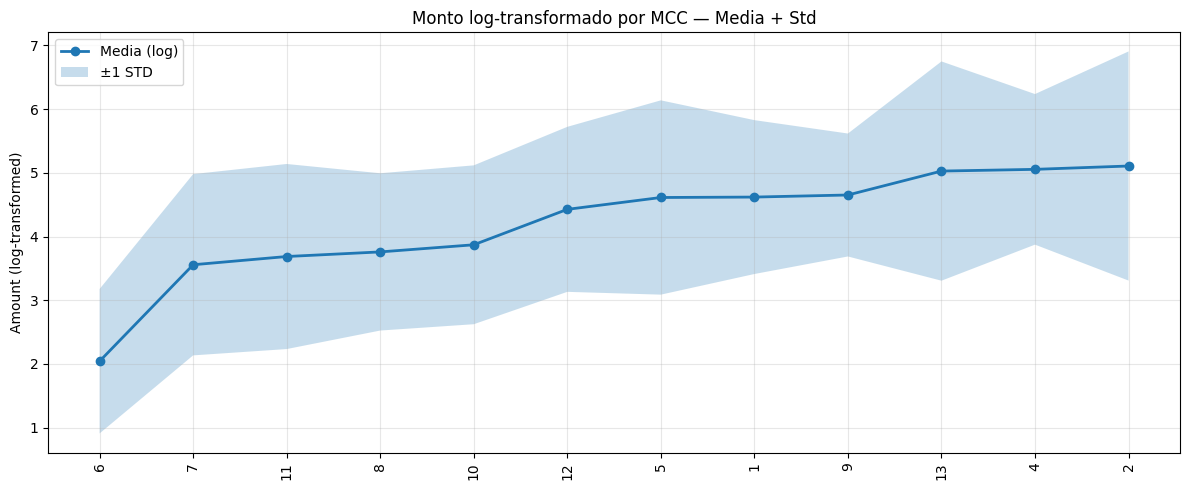

In [150]:
plot_log_amount_by_mcc(data_sessions, amount_log="amount_log", mcc_col="mccg")

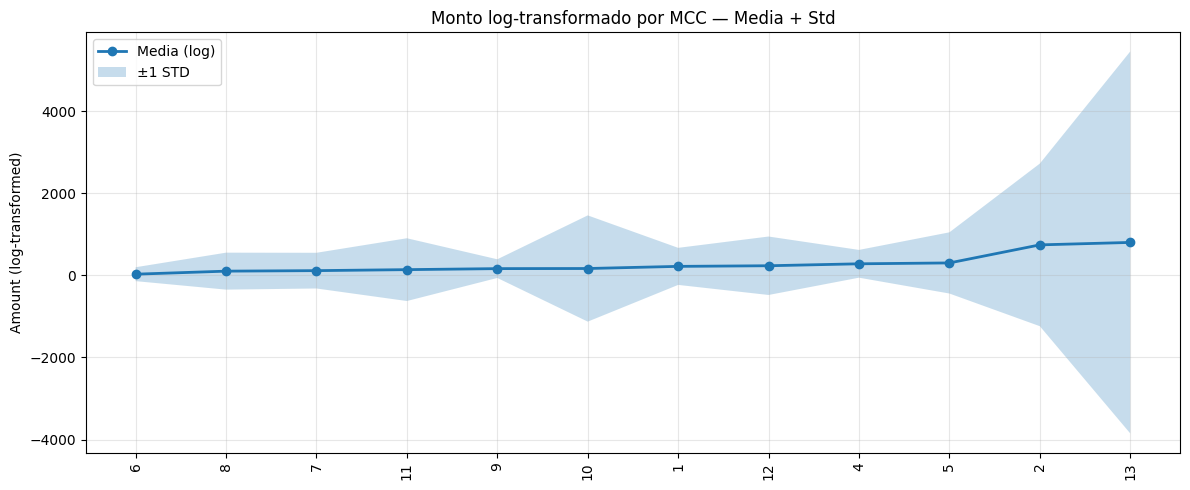

In [151]:
plot_log_amount_by_mcc(data_sessions, amount_log="amount_sol", mcc_col="mccg")

# On Time

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_amount_over_time(df, timestamp_col, amount_col, figsize=(12,5), title=None):
    """
    Plotea cómo varía el monto a lo largo del tiempo (por día):
    - media diaria
    - banda de desviación estándar
    """

    # ------------------------
    # Asegurar tipo datetime
    # ------------------------
    ts = pd.to_datetime(df[timestamp_col], errors="coerce")
    df = df.assign(_ts=ts).dropna(subset=["_ts"])

    # Convertir a día (YYYY-MM-DD)
    df["_day"] = df["_ts"].dt.floor("D")  

    # ------------------------
    # Agregación diaria
    # ------------------------
    grouped = df.groupby("_day")[amount_col]

    mean = grouped.mean()
    std = grouped.std().fillna(0)

    # Ordenar por fecha
    mean = mean.sort_index()
    std = std.loc[mean.index]

    x = mean.index

    # ------------------------
    # Plot
    # ------------------------
    plt.figure(figsize=figsize)

    # Media
    plt.plot(x, mean.values, label="Media diaria", linewidth=2)

    # Banda ± std
    plt.fill_between(
        x,
        np.maximum(mean - std, 0),
        mean + std,
        alpha=0.25,
        label="Desviación estándar"
    )

    plt.ylim(bottom=0)
    plt.grid(alpha=0.3)

    plt.xlabel("Día")
    plt.ylabel(amount_col)
    plt.title(title or f"Evolución temporal de {amount_col}")
    plt.legend()
    plt.tight_layout()
    plt.show()


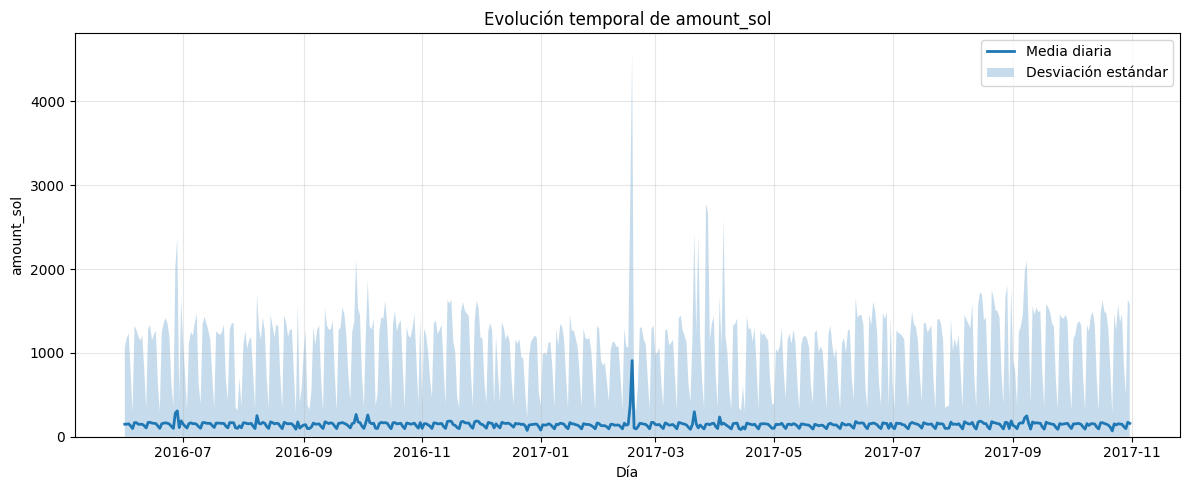

In [153]:
plot_amount_over_time(
    data_sessions,
    timestamp_col="timestamp",
    amount_col="amount_sol"
)

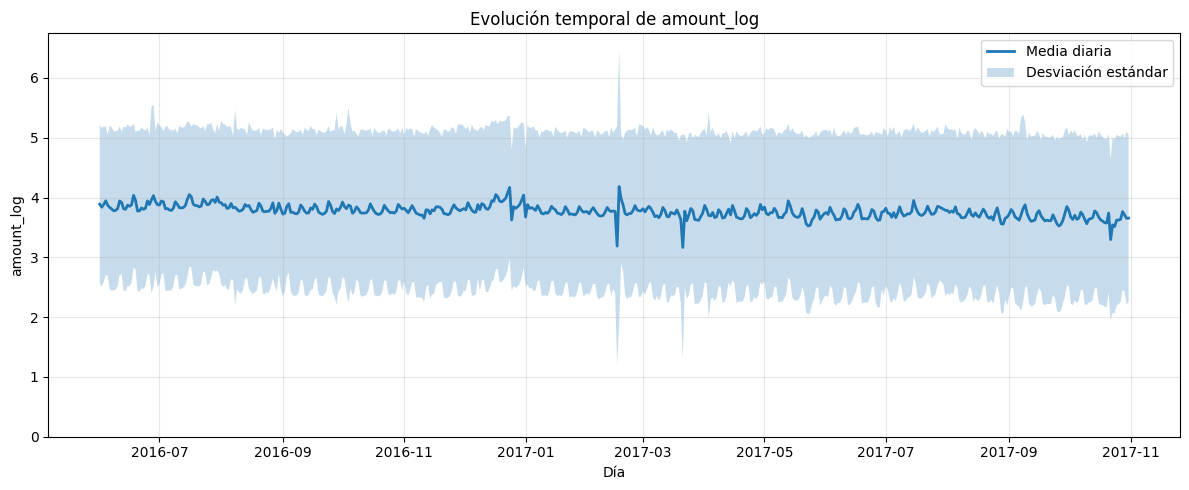

In [154]:
plot_amount_over_time(
    data_sessions,
    timestamp_col="timestamp",
    amount_col="amount_log"
)

# Clients qtys

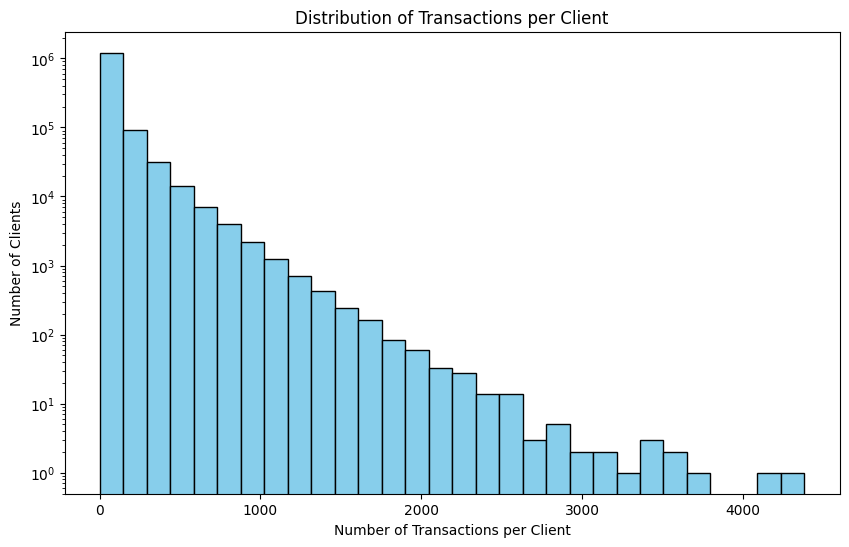

In [167]:
# Contar transacciones por cliente
client_counts = data_sessions.groupby('client_id').size().reset_index(name='num_transactions')

# Histograma de las transacciones por cliente
plt.figure(figsize=(10,6))
plt.hist(client_counts['num_transactions'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Number of Transactions per Client')
plt.ylabel('Number of Clients')
plt.title('Distribution of Transactions per Client')
plt.yscale('log') 
plt.show()

In [155]:
data_sessions.dtypes

id                                                int64
client_id                                        object
mcc                                               int64
amount_sol                                      float64
client_age                                        int64
client_gender                                    object
agency_ubigeo                                   float64
debit_type                                       object
timestamp        datetime64[ns, pytz.FixedOffset(-300)]
mccg                                              int64
windows_time                                     object
day_of_week                                       int64
hour                                              int64
turn_of_day                                       int64
amount_log                                      float64
dtype: object

In [156]:
data_sessions.head()

,id,client_id,mcc,amount_sol,client_age,client_gender,agency_ubigeo,debit_type,timestamp,mccg,windows_time,day_of_week,hour,turn_of_day,amount_log
0,27634759,XxgXt1gGsxk=,5541,100.0,53,M,150140.0,TD,2017-02-05 15:45:25-05:00,8,2017-01-30,6,15,2,4.615121
1,27634839,by4Jhi0/BVI=,5541,20.0,49,M,70102.0,TD,2017-05-19 13:07:38-05:00,8,2017-05-15,4,13,2,3.044522
2,27634758,uY+MrfQgDFU=,5541,80.0,48,F,80108.0,TD,2017-01-31 18:31:02-05:00,8,2017-01-30,1,18,3,4.394449
3,27634763,oTkd8whgjrI=,5541,100.0,48,F,70104.0,TD,2016-11-07 19:26:22-05:00,8,2016-11-07,0,19,3,4.615121
4,27634888,bvbaaID5i+g=,5541,20.0,48,M,150122.0,TD,2016-12-05 00:57:48-05:00,8,2016-12-05,0,0,0,3.044522


In [161]:
config["paths"]["session_records"]

'/Users/jkn/Documents/Projects/university/tensor_behavioral_pattern_mining/data/raw/visa_trx/trx2016.parquet'

In [162]:
output_path = '/Users/jkn/Documents/Projects/university/tensor_behavioral_pattern_mining/data/raw/visa_trx/trx_cured.parquet'
data_sessions.to_parquet(output_path, index=False)

